# Simulating correlated selection

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import pyrepseq as prs

from multiprocessing import Pool
num_cores = 4
#num_cores = int(os.getenv('SLURM_CPUS_PER_TASK'))

nrepeat = 50

plt.style.use('tcrspace.mplstyle')
data_loc = 'data/minervina/beta/'
data_file = 'W_F1_2018_beta.txt.gz'

In [2]:
df = pd.read_csv(data_loc + data_file, sep='\t')
df = df.rename(columns=dict(aaSeqCDR3='cdr3aa'))
df = df[df['cdr3aa'].apply(prs.isvalidcdr3)]
df = df.sample(100000, replace=False)

Calculate a dictionary of neighbors for each amino acid sequence

In [3]:
# presort for faster neighbor finding
df = df.sort_values('cdr3aa')
df = df.reset_index()
all_seqs = set(df['cdr3aa'])
levnbr_dict_aa = {}
for i, seq in df['cdr3aa'].items():
    seqs = prs.levenshtein_neighbors(seq)
    levnbr_dict_aa[i] = []
    for seq in all_seqs.intersection(seqs):
        levnbr_dict_aa[i].append(df.cdr3aa.searchsorted(seq))

Generate multiple selected repertoires for values of the normalization parameter: no correction and Andreas' nbr density deweighted selection.

In [4]:
all_sequences_aa = pd.unique(df['cdr3aa'])
local_densities = prs.calculate_neighbor_numbers(all_sequences_aa)

In [5]:
# calculate coefficient of variation
np.std(local_densities)/np.mean(local_densities)

2.459383004658509

In [6]:
def get_selected_inds(params, df, seed):
    # seed is a dummy variable used to seed the random number generator .. 
    # params include qsel, qrandsel, and corrected/uncorrected
    np.random.seed(seed)    
    qsel = params[0]
    qnbrsel = params[1]
    nbr_correct = params[2] # 1. or 0. for nbr number corrected selection or not
    qstar = nbr_correct*qnbrsel 

    specific_sequences = all_sequences_aa[
        np.random.rand(len(all_sequences_aa))<qsel/(1+qstar*local_densities)]
    specific_neighbors = []
    for seq in specific_sequences:
        for neighbor in prs.levenshtein_neighbors(seq):
            if np.random.rand() < qnbrsel:
                specific_neighbors.append(neighbor)
    specific_all = list(specific_sequences)
    specific_all.extend(specific_neighbors)
    selected_inds = list(df[df['cdr3aa'].isin(set(specific_all))].index)
    return selected_inds 

In [7]:
# generate a dictionary of dictionaries of selected indices
selection_dict = {}
for qnbrsel in [0.,.025,.05,0.1]:
    start = time.time()
    params = [.01,qnbrsel,1.]
    seeds=range(nrepeat)
    with Pool(num_cores) as pool:
        results = [pool.apply_async(get_selected_inds, args=(params,df,seed))
                   for seed in seeds]
        selected_inds = [res.get() for res in results]
    selection_dict[qnbrsel] = [selected_inds,params]
    print(qnbrsel,time.time()-start)

0.0 13.211673498153687
0.025 14.013461351394653
0.05 14.939697504043579
0.1 14.656086444854736


In [8]:
# generate dictionaries of Levenshtein=1 neighbors for selected_inds ... 
def find_seq_nbrs(ind, selected_frame):
    seq = selected_frame.loc[ind]['cdr3aa']
    neighbor_seqs = selected_frame[selected_frame['cdr3aa'].isin(
                        set(prs.levenshtein_neighbors(seq)))]
    neighbor_indices = list(neighbor_seqs.index)
    return (ind, neighbor_indices)

In [9]:
# Find indices of neighbors within each sample
selected_levnbr_dict = {}
for qnbrsel in selection_dict.keys():
    start = time.time()
    print(qnbrsel)
    dict_list = []
    for selected_inds in selection_dict[qnbrsel][0]:
        selected_frame = df.loc[selected_inds]        
        ndict = {}
        with Pool(num_cores) as pool:
            results = [pool.apply_async(find_seq_nbrs,
                                        args=(ind,selected_frame))
                       for ind in selected_inds]
            thing = [res.get() for res in results]
        for (a,b) in thing:
            ndict[a]=b
        dict_list.append(ndict)
    print(qnbrsel,time.time()-start)
    selected_levnbr_dict[qnbrsel] = [dict_list, selection_dict[qnbrsel][1]]  

0.0
0.0 86.70873808860779
0.025
0.025 90.51535129547119
0.05
0.05 98.28971195220947
0.1
0.1 97.11243343353271


## Let's look at the near-coincidence plots for this implementation of selection

In [10]:
def calc_stats(sequencess,hist_back_norm):
    ratios = []
    hists = []
    for i, sampled_sequences in enumerate(sequencess):
        hist_norm = prs.pcDelta(sampled_sequences, pseudocount=0.0)
        hists.append(hist_norm)
        ratio = (hist_norm / hist_back_norm)
        ratios.append(list(ratio))
    return ratios, hists

In [11]:
back_norms, bins = prs.load_pcDelta_background()
hist_back_norm = back_norms['beta']

In [12]:
# code to plot the histograms of coincidence freqs and their ratios to background values
def plot_coinc_freq(selected_indss,df,params):
    # use selected indices to get sampled sequences from the input dataframe df (often same as df_bkgd)
    sampled_sequencess = []
    
    for inds in selected_indss:
        seqs = list(df.loc[inds]['cdr3aa'].values)
        sampled_sequencess.append(seqs)
        M = len(seqs)

    # set up the plots and choose binning
    fig, axes = plt.subplots(figsize=(6.5, 2.2), ncols=2, nrows=1, sharex=True)
    
    # plot the background coincidence freqs .. use df_bkgd to get seq pair dists
    axes[0].plot(bins[:-1], hist_back_norm, '-o', label='Background', color='C0')
    
    # calculate the coincidence histograms for the sampled sequences
    ratios, hists = calc_stats(sampled_sequencess, hist_back_norm)
    for hist in hists:
        axes[0].plot(bins[:-1], hist, '-', alpha=.2, color='k')
    for ratio in ratios:
        axes[1].plot(bins[:-1], ratio, '-', alpha=.2, color='k')
    
    # plot the mean of the sampled data histograms
    hists = np.array(hists)
    l, = axes[0].plot(bins[:-1], hists.mean(axis=0), '-o', label='Data mean', color='C1')
    axes[1].plot(bins[:-1], hists.mean(axis=0)/hist_back_norm, '-o', color=l.get_color(),label='Data mean')
    thing = hists.mean(axis=0)/hist_back_norm
    
    # formatting stuff
    for ax in axes:
        ax.set_yscale('log')
        ax.set_xlim(-1,12)
        ax.grid()
    axes[0].set_ylim(2e-7,5e-1)
    axes[1].set_ylim(2e-1,1e3)
    axes[0].legend(loc='lower right')
    axes[1].legend()
    axes[0].set_xlabel(r'$\Delta$ (CDR3$\beta$ Dist.)')
    axes[0].set_ylabel(r'$p_C(\Delta)$')
    axes[1].set_xlabel(r'$\Delta$ (CDR3$\beta$ Dist.)')
    axes[1].set_ylabel(r'$p_C\,/\,p_{C,back}$')

    return fig, (axes[0],axes[1])

0.0
0.025
0.05
0.1


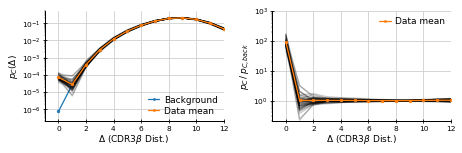

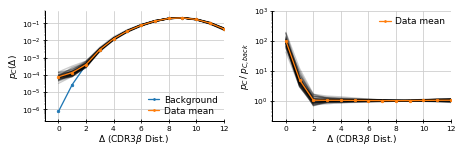

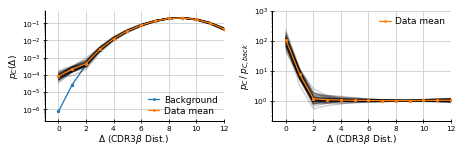

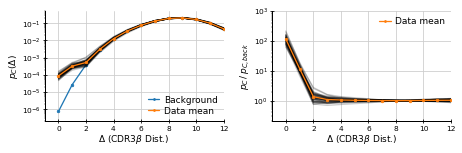

In [13]:
# now plot the near-coincidence freqs and ratio to bkgd values for chosen selection parameter

for qnbrsel in selection_dict.keys():
    print(qnbrsel)
    selected_indss = selection_dict[qnbrsel][0]
    params = selection_dict[qnbrsel][1]
    fig,_ = plot_coinc_freq(selected_indss,df,params)
    fig.tight_layout()
    fig.savefig(f'figures/raw/figureS2_{qnbrsel}.svg')

In [14]:
local_density_dict = dict(zip(df.index, prs.calculate_neighbor_numbers(df['cdr3aa'])))

In [15]:
# This gets the histogram of selection vs nbr number in the input dataframe
def get_selection_stats(inds_array):
    bins = np.arange(0, 40, 3)
    hists = []
    for inds in inds_array:
        # local_density refers to the background sequences
        thing = [local_density_dict[i] for i in inds]
        a, b = np.histogram(thing, bins=bins)
        hists.append(a)
    return hists, bins

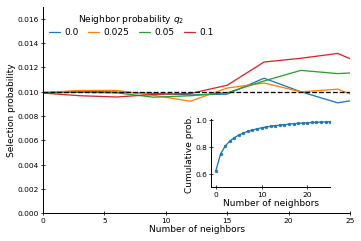

In [16]:
# plot node selection fraction versus neighbor number class
fig, ax = plt.subplots(1,1,figsize=(5.5, 3.8))
ratios = []
qsel=.01

for qnbrsel in selection_dict.keys():
    selected_indss = selection_dict[qnbrsel][0]
    hists, b = get_selection_stats(selected_indss)
    hist_selected = sum(hists)/len(hists)
    hist_bkgd, _ = np.histogram(list(local_density_dict.values()), bins=b)
    ratio = hist_selected/hist_bkgd
    ax.plot(b[:-1], ratio, label=qnbrsel)

ax.axhline(y=qsel, color='k', linestyle='dashed')

ax.legend(title='Neighbor probability $q_2$', ncol=4, loc='upper left')
ax.set_ylim(.0,.017)
ax.set_xlim(0, 25)
ax.set_ylabel('Selection probability')
ax.set_xlabel('Number of neighbors')

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.55, 0.22, 0.3, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
nbr, count = np.unique(list(local_density_dict.values()), return_counts=True)
ax2.plot(nbr, np.cumsum(count/np.sum(count)), 'o-')
ax2.set_xlim(-1, 25)
ax2.set_ylim(.5,1.01)
ax2.set_xlabel('Number of neighbors')
ax2.set_ylabel('Cumulative prob.')

fig.savefig('figures/raw/figureS1.svg')

In [17]:
np.cumsum(count/np.sum(count))[10]

0.9437400000000001